## Predict defaults in student loan applications

In [19]:
# import the desired packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import timeit
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import graphviz

**1. Load the data set loandata.csv into Python.**


In [20]:
# load dataset using read_csv
loan_df = pd.read_csv('/Users/macbookpro/Desktop/Machine Learning/Assignments/Assignment 3/loandata.csv')
loan_df.head() # print first five rows

,field,selectiveCollege,sex,Default,loanAmount,graduationYear
0,BUSINESS,0,Male,No,59265,2012
1,STEM,0,Female,No,74496,2011
2,STEM,0,Male,No,36667,2006
3,BUSINESS,0,Male,No,40551,2007
4,BUSINESS,1,Male,No,38566,2014


**2. The data set contains some categorical predictors. Sklearn, which you should use for this exercise, can only handle numerical predictors. Translate the categorical predictors into numerical predictors.**

In [21]:
# transform the categorical attributes into numerical ones [1,0] for K-1 categories
loan_df_dummies = pd.get_dummies(loan_df, columns=['field', 'sex', 'Default'], drop_first = True)
loan_df_dummies.head()  # print first five rows

,selectiveCollege,loanAmount,graduationYear,field_HUMANITIES,field_STEM,sex_Male,Default_Yes
0,0,59265,2012,0,0,1,0
1,0,74496,2011,0,1,0,0
2,0,36667,2006,0,1,1,0
3,0,40551,2007,0,0,1,0
4,1,38566,2014,0,0,1,0


**3. Shuffle the data set and split it into 50% training data, 25% validation data and 25% test data.**

In [22]:
# retrieve the dependent and independent variables into two different datasets
X_loan = loan_df_dummies.iloc[:,:-1] # similar as loc but use indexes (everything until last column)
y_loan = loan_df_dummies.iloc[:,-1] # retrieve last column only

In [23]:
# split the dataframe into training set and other and add random seed so the output stays the same 
X_train, X_other, y_train, y_other = train_test_split(X_loan, y_loan, train_size=0.5, random_state=42)
# split the other set into the validation and test sets and add random seed so the output stays the same 
X_validation, X_test, y_validation, y_test = train_test_split(X_other, y_other, train_size=0.5, random_state=42)

In [24]:
# check that the split was done correctly
print("Training set is", X_train.shape[0]*100/X_loan.shape[0],"% of the total data set")  # percentage of training set
print("Validation set is",X_validation.shape[0]*100/X_loan.shape[0],"% of the total data set") # percentage of validation set
print("Test set is",X_test.shape[0]*100/X_loan.shape[0],"% of the total data set") # percentage of test set

Training set is 50.0 % of the total data set
Validation set is 25.0 % of the total data set
Test set is 25.0 % of the total data set


**4. Calculate the accuracy of the naive benchmark (majority predictor) on the validation set.**

In [25]:
naive_class = DummyClassifier(strategy = "most_frequent") # initialise naive classifier on majority predictor
naive_class.fit(X_train, y_train) # fit the model 
accuracy = naive_class.score(X_validation, y_validation) # calculate the acuracy the model 
print("The accuracy of the naive benchmark on the validation set is ", round(accuracy, 5)*100,'%')

The accuracy of the naive benchmark on the validation set is  75.446 %


**5. Train a decision tree and calculate the accuracy of this tree on the training and validation set. Choose an appropriate maximum depth and justify your choice. (Look at the max depth parameter). All other settings should be kept at default values. What do you think of this classifier?**

The best classifier is for max depth = 2 with accuracy 86.931 %


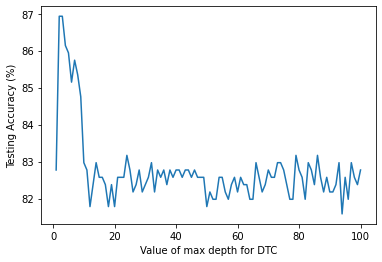

In [26]:
# we will use the DecisionTreeClassifier function available in the sklearn package
score_list = [] # initialise an empty list that will iteratively be appended the % accuracy
depth_range = [i for i in range(1,101)] # list containing values of max_depth from 1 to 100
for depth in depth_range: # for loop going through all the values of max depth at a time
    DTC = DecisionTreeClassifier(max_depth = depth) # initialise a DecisionTreeClassifier for the value of max_depth
    DTC.fit(X_train, y_train.values.ravel()) # fit the model with the training data 
    y_pred = DTC.predict(X_validation) # predict the validation set using the trained model
    # find the number of correctly predicted data and divide by the total number of rows and append to score_list 
    score_list.append(metrics.accuracy_score(y_validation, y_pred)*100)

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between max_depth and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1,101), score_list)
plt.xlabel('Value of max depth for DTC')
plt.ylabel('Testing Accuracy (%)')
print('The best classifier is for max depth =', depth_range[score_list.index(max(score_list))], 'with accuracy', 
      round(max(score_list), 3), '%')

In [27]:
# create new decision tree classifier with the max_depth that gives the best accuracy on the training set
DTC = DecisionTreeClassifier(max_depth = depth_range[score_list.index(max(score_list))])
DTC.fit(X_train, y_train) # fit training data
prediction_train = DTC.predict(X_train) # predict training data
print("The accuracy of the tree is", round(metrics.accuracy_score(y_train, prediction_train)*100,3),'%')

The accuracy of the tree is 87.228 %


In [28]:
# create new decision tree classifier with the max_depth that gives the best accuracy on the validation set
DTC = DecisionTreeClassifier(max_depth = depth_range[score_list.index(max(score_list))])
DTC.fit(X_train, y_train) # fit training data
prediction_validation = DTC.predict(X_validation) # predict validation data
print("The accuracy of the tree is", round(metrics.accuracy_score(y_validation, prediction_validation)*100,3),'%')

The accuracy of the tree is 86.931 %


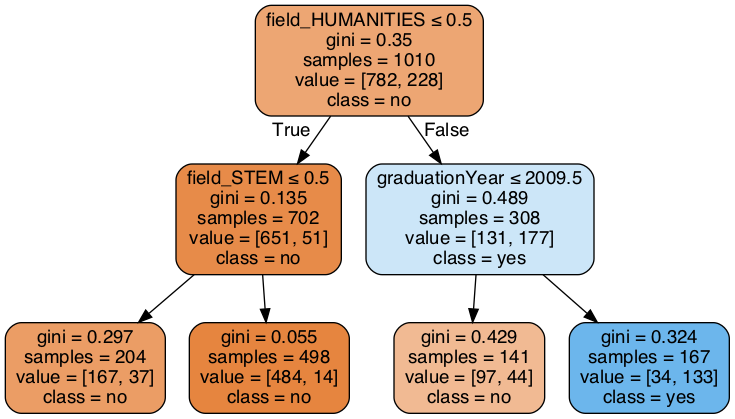

In [29]:
# visualise the decision tree using StringIO(), graphviz and pydotplus
dot_data = StringIO()
export_graphviz(DTC, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_loan.columns,class_names=['no','yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

**6. Try a random forest algorithm instead. Use different number of estimators and plot the accuracy (on training and validation data) as a function of the number of estimators. (Look at the n estimators parameter).**

The best classifier is for n_estimators for validation = 25 with accuracy 86.139 %
The best classifier is for n_estimators for validation = 44 with accuracy 100.0 %


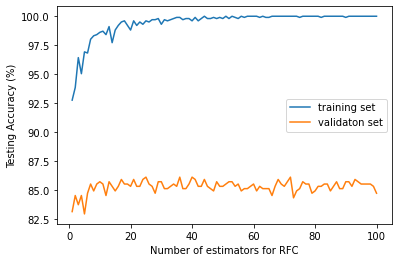

In [30]:
# we will use the RandomForestClassifier function available in the sklearn package
score_list_train = [] # initialise an empty list that will iteratively be appended the % accuracy of training set
score_list_validation = [] # initialise empty list that will iteratively be appended the % accuracy of validation set
time_list = []
estimator_range = [i for i in range(1,101)] # list containing values of max_depth from 1 to 100
for estimator in estimator_range: # for loop going through all the values of max depth at a time
    RFC = RandomForestClassifier(n_estimators = estimator) # initialise a RandomForestClassifier for n_estimators
    RFC.fit(X_train, y_train.values.ravel()) # fit the model with the training data 
    time_train = timeit.timeit(lambda: RFC.fit(X_train, y_train.values.ravel()), number = 1)
    y_pred_train = RFC.predict(X_train) # predict the validation set using the trained model
    y_pred_validation = RFC.predict(X_validation) # predict the validation set using the trained model
    # find the number of correctly predicted data and divide by the total number of rows and append to cor_class_list 
    score_list_train.append(metrics.accuracy_score(y_pred_train, y_train)*100)
    score_list_validation.append(metrics.accuracy_score(y_pred_validation, y_validation)*100)
    time_list.append(time_train)
    
# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1,101), score_list_train)
plt.plot(range(1,101), score_list_validation)
plt.xlabel('Number of estimators for RFC')
plt.ylabel('Testing Accuracy (%)')
plt.legend(["training set", "validaton set"], loc ="center right")
print('The best classifier is for n_estimators for validation =', 
      estimator_range[score_list_validation.index(max(score_list_validation))], 'with accuracy', 
      round(max(score_list_validation), 3), '%')
print('The best classifier is for n_estimators for validation =', 
      estimator_range[score_list_train.index(max(score_list_train))], 'with accuracy', 
      round(max(score_list_train), 3), '%')

**7. Also plot the training time (vs the number of estimators) for the random forest models in the previous step. What appropriate number of estimators would you choose? Why?**


The best classifier of the validation set takes t = 0.028 ms


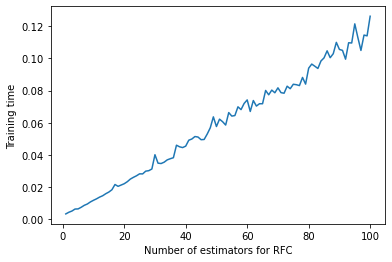

In [31]:
plt.plot(range(1,101), time_list)
plt.xlabel('Number of estimators for RFC')
plt.ylabel('Training time')
print('The best classifier of the validation set takes t =', 
      round(time_list[score_list_validation.index(max(score_list_validation))],3),'ms')